In [ ]:
import numpy as np

In [ ]:
import pandas as pd

In [ ]:
import os

In [ ]:
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Layer, Flatten, Embedding, Reshape
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tqdm import tqdm
import plotly.express as px
import torch
import torchvision
from torchvision import transforms as T # for simplifying the transforms
plt.rcParams['font.size'] =  12

2023-01-01 21:58:42.861672: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-01 21:58:52.486167: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-01 21:58:52.486692: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-01 21:58:52.486721: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [ ]:
## Now, we import timm, torchvision image models
!pip install timm # kaggle doesnt have it installed by default
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

In [ ]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import sys
from tqdm import tqdm
import time
import copy

In [ ]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [ ]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [ ]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
            T.RandomErasing(p=0.2, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "val/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)


In [ ]:

dataset_path = "/home2/vivek.talwar/final_oral"

train_dir = "/home2/vivek.talwar/final_oral/train"

val_dir = "/home2/vivek.talwar/final_oral/val"

test_dir = "/home2/vivek.talwar/final_oral/test"

In [ ]:
import os
(train_loader, train_data_len) = get_data_loaders(dataset_path, 128, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [ ]:

classes = get_classes("/home2/vivek.talwar/final_oral/train")
print(classes, len(classes))

['non-suspicious', 'suspicious'] 2


In [ ]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [ ]:
print(len(train_loader), len(val_loader), len(test_loader))

11 13 14


In [ ]:
print(train_data_len, valid_data_len, test_data_len)

1344 412 422


In [ ]:
# Set up variables for pre-processing
batch_size = 16
epochs = 50
IMG_HEIGHT = 224
IMG_WIDTH = 224

Class names:  ['non-suspicious' 'suspicious']
Found 1344 images belonging to 2 classes.


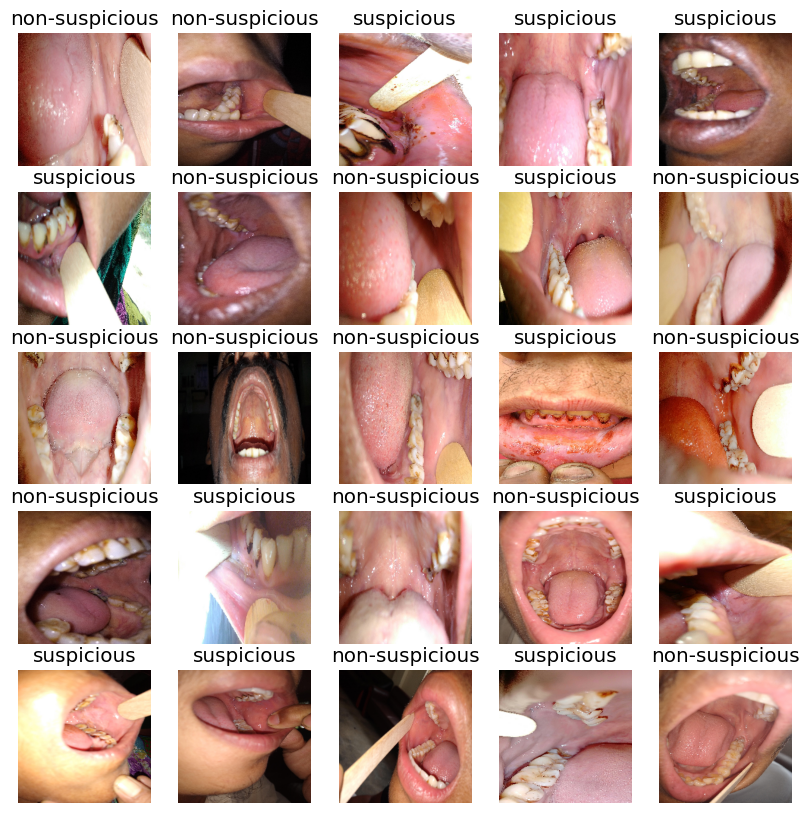

In [ ]:

import scipy

import os
import pathlib
from time import time
# Visualize some images
train_root = pathlib.Path(train_dir)
class_names = sorted([j.name.split('/')[-1] for j in train_root.iterdir()])
class_names = np.array(class_names)
print('Class names: ', class_names)

img_gen = ImageDataGenerator(rescale = 1./255)
sample_train_data_gen = img_gen.flow_from_directory(batch_size = 32,
                                                    directory = train_dir,
                                                    shuffle = True,
                                                    target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                    classes = list(class_names))
                                                 
sample_images, sample_labels = next(sample_train_data_gen)

def show_batch(img_batch, label_batch):
    plt.figure(figsize = (10, 10))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(sample_images[i])
        plt.title(class_names[sample_labels[i] == 1][0])
        plt.axis('off')
        
show_batch(sample_images, sample_labels)

In [ ]:
batch_size=16

In [ ]:
train_image_generator = ImageDataGenerator(rescale = 1./255,
                                           rotation_range = 45,
                                           width_shift_range = 0.20,
                                           height_shift_range = 0.20,
                                           horizontal_flip = True,
                                           zoom_range = 0.5)

val_image_generator = ImageDataGenerator(rescale = 1./255)
test_image_generator = ImageDataGenerator(rescale = 1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size = batch_size,
                                                           directory = train_dir,
                                                           shuffle = True,
                                                           target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode = 'categorical')

val_data_gen = val_image_generator.flow_from_directory(batch_size = batch_size,
                                                       directory = val_dir,
                                                       target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                       class_mode = 'categorical')

test_data_gen = test_image_generator.flow_from_directory(test_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 class_mode='categorical')

Found 1344 images belonging to 2 classes.
Found 412 images belonging to 2 classes.
Found 422 images belonging to 2 classes.


In [ ]:

# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:


img_size = 512
base_model = DenseNet201(include_top = False,
                       weights = 'imagenet',
                       input_shape = (img_size,img_size,3))

2023-01-01 22:02:45.320360: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-01 22:02:49.996244: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9635 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5
2023-01-01 22:02:49.996889: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9635 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:03:00.0, compute capability: 7.5
2023-01-01 22:02:49.997436: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/tas

In [ ]:
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 256, 256, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

 conv2_block3_concat (Concatena  (None, 128, 128, 16  0          ['conv2_block2_concat[0][0]',    
 te)                            0)                                'conv2_block3_2_conv[0][0]']    
                                                                                                  
 conv2_block4_0_bn (BatchNormal  (None, 128, 128, 16  640        ['conv2_block3_concat[0][0]']    
 ization)                       0)                                                                
                                                                                                  
 conv2_block4_0_relu (Activatio  (None, 128, 128, 16  0          ['conv2_block4_0_bn[0][0]']      
 n)                             0)                                                                
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 128, 128, 12  20480       ['conv2_block4_0_relu[0][0]']    
          

 conv3_block1_1_conv (Conv2D)   (None, 64, 64, 128)  16384       ['conv3_block1_0_relu[0][0]']    
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 64, 64, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 64, 64, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_2_conv (Conv2D)   (None, 64, 64, 32)   36864       ['conv3_block1_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block5_2_conv (Conv2D)   (None, 64, 64, 32)   36864       ['conv3_block5_1_relu[0][0]']    
                                                                                                  
 conv3_block5_concat (Concatena  (None, 64, 64, 288)  0          ['conv3_block4_concat[0][0]',    
 te)                                                              'conv3_block5_2_conv[0][0]']    
                                                                                                  
 conv3_block6_0_bn (BatchNormal  (None, 64, 64, 288)  1152       ['conv3_block5_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block6_0_relu (Activatio  (None, 64, 64, 288)  0          ['conv3_block6_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv3_block10_0_relu (Activati  (None, 64, 64, 416)  0          ['conv3_block10_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block10_1_conv (Conv2D)  (None, 64, 64, 128)  53248       ['conv3_block10_0_relu[0][0]']   
                                                                                                  
 conv3_block10_1_bn (BatchNorma  (None, 64, 64, 128)  512        ['conv3_block10_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_blo

 conv4_block2_0_bn (BatchNormal  (None, 32, 32, 288)  1152       ['conv4_block1_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_0_relu (Activatio  (None, 32, 32, 288)  0          ['conv4_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_1_conv (Conv2D)   (None, 32, 32, 128)  36864       ['conv4_block2_0_relu[0][0]']    
                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 32, 32, 32)   36864       ['conv4_block6_1_relu[0][0]']    
                                                                                                  
 conv4_block6_concat (Concatena  (None, 32, 32, 448)  0          ['conv4_block5_concat[0][0]',    
 te)      

 conv4_block10_2_conv (Conv2D)  (None, 32, 32, 32)   36864       ['conv4_block10_1_relu[0][0]']   
                                                                                                  
 conv4_block10_concat (Concaten  (None, 32, 32, 576)  0          ['conv4_block9_concat[0][0]',    
 ate)                                                             'conv4_block10_2_conv[0][0]']   
                                                                                                  
 conv4_block11_0_bn (BatchNorma  (None, 32, 32, 576)  2304       ['conv4_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block11_0_relu (Activati  (None, 32, 32, 576)  0          ['conv4_block11_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block15_0_relu (Activati  (None, 32, 32, 704)  0          ['conv4_block15_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block15_1_conv (Conv2D)  (None, 32, 32, 128)  90112       ['conv4_block15_0_relu[0][0]']   
                                                                                                  
 conv4_block15_1_bn (BatchNorma  (None, 32, 32, 128)  512        ['conv4_block15_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block15_1_relu (Activati  (None, 32, 32, 128)  0          ['conv4_block15_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block19_1_relu (Activati  (None, 32, 32, 128)  0          ['conv4_block19_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block19_2_conv (Conv2D)  (None, 32, 32, 32)   36864       ['conv4_block19_1_relu[0][0]']   
                                                                                                  
 conv4_block19_concat (Concaten  (None, 32, 32, 864)  0          ['conv4_block18_concat[0][0]',   
 ate)                                                             'conv4_block19_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block23_concat (Concaten  (None, 32, 32, 992)  0          ['conv4_block22_concat[0][0]',   
 ate)                                                             'conv4_block23_2_conv[0][0]']   
                                                                                                  
 conv4_block24_0_bn (BatchNorma  (None, 32, 32, 992)  3968       ['conv4_block23_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block24_0_relu (Activati  (None, 32, 32, 992)  0          ['conv4_block24_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block24_1_conv (Conv2D)  (None, 32, 32, 128)  126976      ['conv4_block24_0_relu[0][0]']   
          

 on)                            )                                                                 
                                                                                                  
 conv4_block28_1_conv (Conv2D)  (None, 32, 32, 128)  143360      ['conv4_block28_0_relu[0][0]']   
                                                                                                  
 conv4_block28_1_bn (BatchNorma  (None, 32, 32, 128)  512        ['conv4_block28_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block28_1_relu (Activati  (None, 32, 32, 128)  0          ['conv4_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block32_1_relu (Activati  (None, 32, 32, 128)  0          ['conv4_block32_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block32_2_conv (Conv2D)  (None, 32, 32, 32)   36864       ['conv4_block32_1_relu[0][0]']   
                                                                                                  
 conv4_block32_concat (Concaten  (None, 32, 32, 1280  0          ['conv4_block31_concat[0][0]',   
 ate)                           )                                 'conv4_block32_2_conv[0][0]']   
                                                                                                  
 conv4_block33_0_bn (BatchNorma  (None, 32, 32, 1280  5120       ['conv4_block32_concat[0][0]']   
 lization)                      )                                                                 
          

                                                                                                  
 conv4_block37_0_bn (BatchNorma  (None, 32, 32, 1408  5632       ['conv4_block36_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block37_0_relu (Activati  (None, 32, 32, 1408  0          ['conv4_block37_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block37_1_conv (Conv2D)  (None, 32, 32, 128)  180224      ['conv4_block37_0_relu[0][0]']   
                                                                                                  
 conv4_block37_1_bn (BatchNorma  (None, 32, 32, 128)  512        ['conv4_block37_1_conv[0][0]']   
 lization)

 conv4_block41_1_conv (Conv2D)  (None, 32, 32, 128)  196608      ['conv4_block41_0_relu[0][0]']   
                                                                                                  
 conv4_block41_1_bn (BatchNorma  (None, 32, 32, 128)  512        ['conv4_block41_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block41_1_relu (Activati  (None, 32, 32, 128)  0          ['conv4_block41_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block41_2_conv (Conv2D)  (None, 32, 32, 32)   36864       ['conv4_block41_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block45_2_conv (Conv2D)  (None, 32, 32, 32)   36864       ['conv4_block45_1_relu[0][0]']   
                                                                                                  
 conv4_block45_concat (Concaten  (None, 32, 32, 1696  0          ['conv4_block44_concat[0][0]',   
 ate)                           )                                 'conv4_block45_2_conv[0][0]']   
                                                                                                  
 conv4_block46_0_bn (BatchNorma  (None, 32, 32, 1696  6784       ['conv4_block45_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block46_0_relu (Activati  (None, 32, 32, 1696  0          ['conv4_block46_0_bn[0][0]']     
 on)      

                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv5_block1_1_relu[0][0]']    
                                                                                                  
 conv5_block1_concat (Concatena  (None, 16, 16, 928)  0          ['pool4_pool[0][0]',             
 te)                                                              'conv5_block1_2_conv[0][0]']    
                                                                                                  
 conv5_block2_0_bn (BatchNormal  (None, 16, 16, 928)  3712       ['conv5_block1_concat[0][0]']    
 ization) 

 te)                            )                                 'conv5_block5_2_conv[0][0]']    
                                                                                                  
 conv5_block6_0_bn (BatchNormal  (None, 16, 16, 1056  4224       ['conv5_block5_concat[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv5_block6_0_relu (Activatio  (None, 16, 16, 1056  0          ['conv5_block6_0_bn[0][0]']      
 n)                             )                                                                 
                                                                                                  
 conv5_block6_1_conv (Conv2D)   (None, 16, 16, 128)  135168      ['conv5_block6_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block10_1_conv (Conv2D)  (None, 16, 16, 128)  151552      ['conv5_block10_0_relu[0][0]']   
                                                                                                  
 conv5_block10_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv5_block10_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block10_1_relu (Activati  (None, 16, 16, 128)  0          ['conv5_block10_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block10_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv5_block10_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv5_block14_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv5_block14_1_relu[0][0]']   
                                                                                                  
 conv5_block14_concat (Concaten  (None, 16, 16, 1344  0          ['conv5_block13_concat[0][0]',   
 ate)                           )                                 'conv5_block14_2_conv[0][0]']   
                                                                                                  
 conv5_block15_0_bn (BatchNorma  (None, 16, 16, 1344  5376       ['conv5_block14_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv5_blo

 conv5_block19_0_bn (BatchNorma  (None, 16, 16, 1472  5888       ['conv5_block18_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv5_block19_0_relu (Activati  (None, 16, 16, 1472  0          ['conv5_block19_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv5_block19_1_conv (Conv2D)  (None, 16, 16, 128)  188416      ['conv5_block19_0_relu[0][0]']   
                                                                                                  
 conv5_block19_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv5_block19_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv5_block23_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv5_block23_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block23_1_relu (Activati  (None, 16, 16, 128)  0          ['conv5_block23_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block23_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv5_block23_1_relu[0][0]']   
                                                                                                  
 conv5_block23_concat (Concaten  (None, 16, 16, 1632  0          ['conv5_block22_concat[0][0]',   
 ate)     

 conv5_block27_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv5_block27_1_relu[0][0]']   
                                                                                                  
 conv5_block27_concat (Concaten  (None, 16, 16, 1760  0          ['conv5_block26_concat[0][0]',   
 ate)                           )                                 'conv5_block27_2_conv[0][0]']   
                                                                                                  
 conv5_block28_0_bn (BatchNorma  (None, 16, 16, 1760  7040       ['conv5_block27_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv5_block28_0_relu (Activati  (None, 16, 16, 1760  0          ['conv5_block28_0_bn[0][0]']     
 on)                            )                                                                 
          

                                                                                                  
 conv5_block32_0_relu (Activati  (None, 16, 16, 1888  0          ['conv5_block32_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv5_block32_1_conv (Conv2D)  (None, 16, 16, 128)  241664      ['conv5_block32_0_relu[0][0]']   
                                                                                                  
 conv5_block32_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv5_block32_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block32_1_relu (Activati  (None, 16, 16, 128)  0          ['conv5_block32_1_bn[0][0]']     
 on)      

In [ ]:
last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
outputs = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
model_name = "DenseNet201.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 15, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.3, 
                                            min_lr=0.00000001)

In [ ]:

history = model.fit(train_data_gen,
                    epochs=50,
                    validation_data=val_data_gen,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])

In [ ]:

y_test = test_data_gen.classes
y_preds = model.predict(test_data_gen)
y_pred = np.argmax(y_preds,axis=1)

Epoch 1/50


2023-01-01 22:04:39.651045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2023-01-01 22:04:43.641077: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-01 22:04:45.810445: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x3decb6d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-01 22:04:45.810501: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-01-01 22:04:45.810514: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-01-01 22:04:45.810522: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-01-01 22:04:45.810528: I tensorflow/compiler/xla/service/service.cc:181] 

84/84 [==============================] - ETA: 0s - loss: 0.5717 - accuracy: 0.7202
Epoch 1: val_loss improved from inf to 1.24555, saving model to DenseNet201.h5
84/84 [==============================] - 188s 1s/step - loss: 0.5717 - accuracy: 0.7202 - val_loss: 1.2455 - val_accuracy: 0.5073 - lr: 1.0000e-04
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4538 - accuracy: 0.7879
Epoch 2: val_loss improved from 1.24555 to 0.65446, saving model to DenseNet201.h5
84/84 [==============================] - 96s 1s/step - loss: 0.4538 - accuracy: 0.7879 - val_loss: 0.6545 - val_accuracy: 0.6748 - lr: 1.0000e-04
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.3995 - accuracy: 0.8259
Epoch 3: val_loss did not improve from 0.65446
84/84 [==============================] - 91s 1s/step - loss: 0.3995 - accuracy: 0.8259 - val_loss: 0.8194 - val_accuracy: 0.6917 - lr: 1.0000e-04
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.3524 - accu

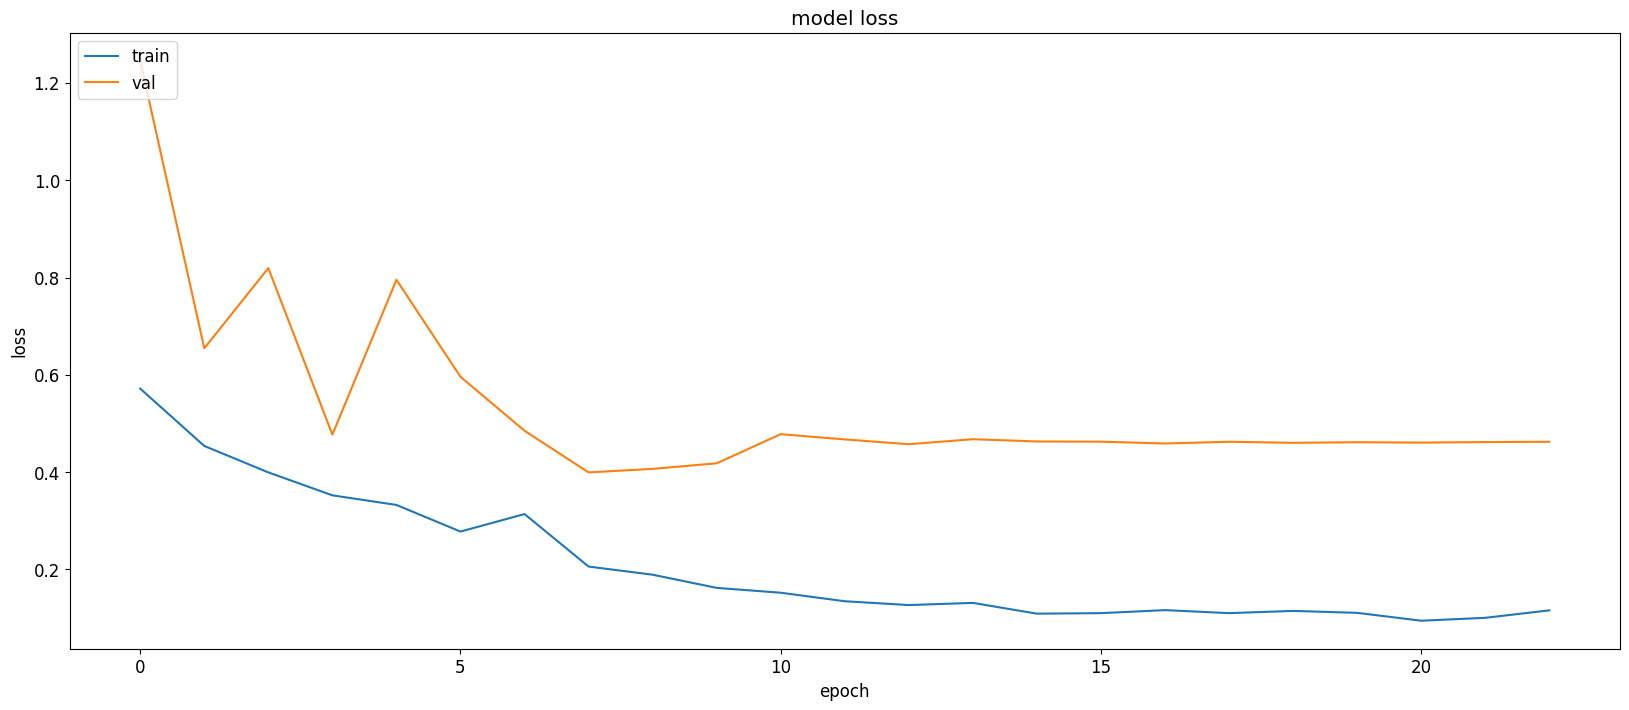

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

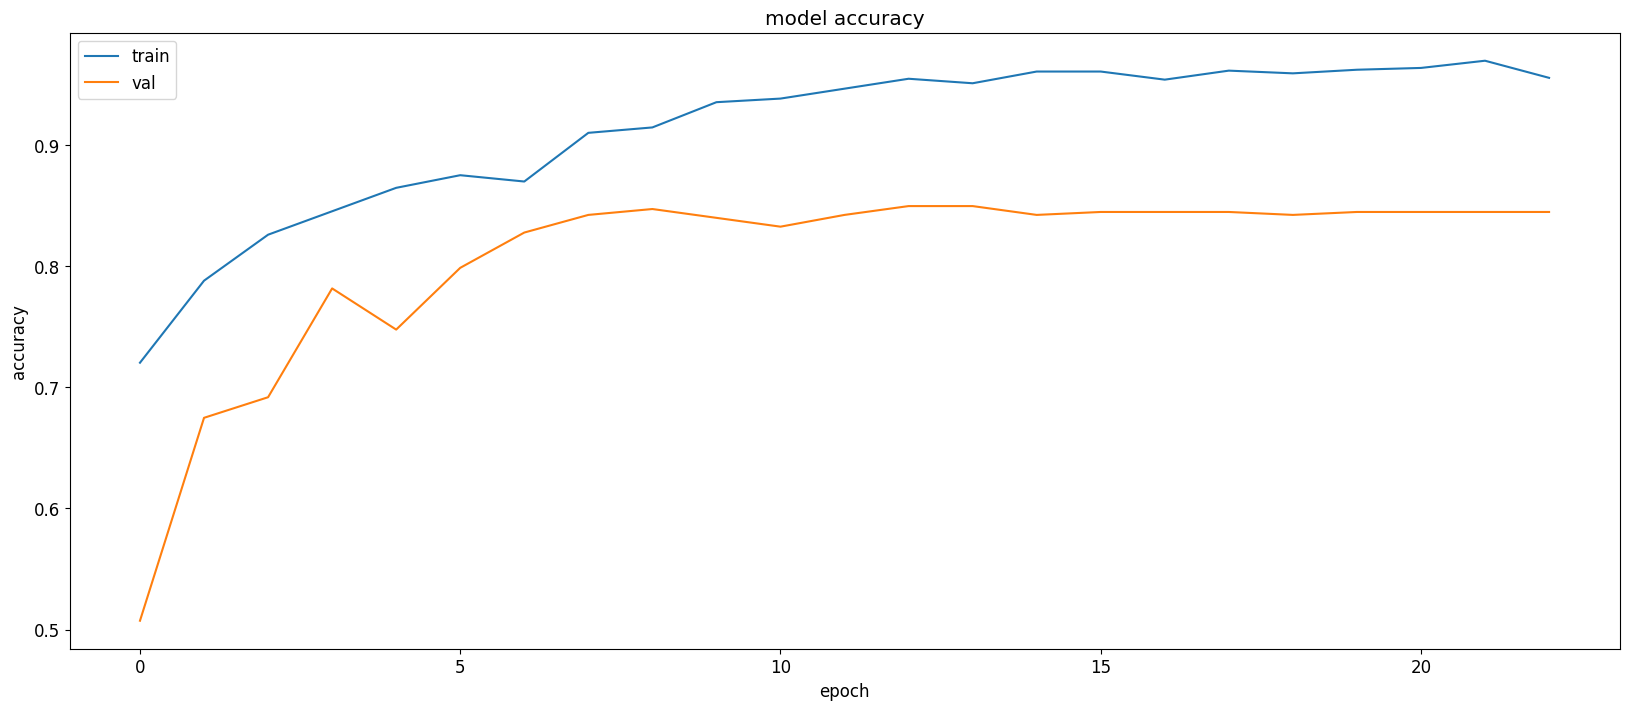

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:


y_test = test_data_gen.classes
y_preds = model.predict(test_data_gen)
y_pred = np.argmax(y_preds,axis=1)

27/27 [==============================] - 17s 603ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,y_pred,target_names = classes))

                precision    recall  f1-score   support

non-suspicious       0.87      0.83      0.85       206
    suspicious       0.84      0.88      0.86       216

      accuracy                           0.86       422
     macro avg       0.86      0.85      0.86       422
  weighted avg       0.86      0.86      0.86       422



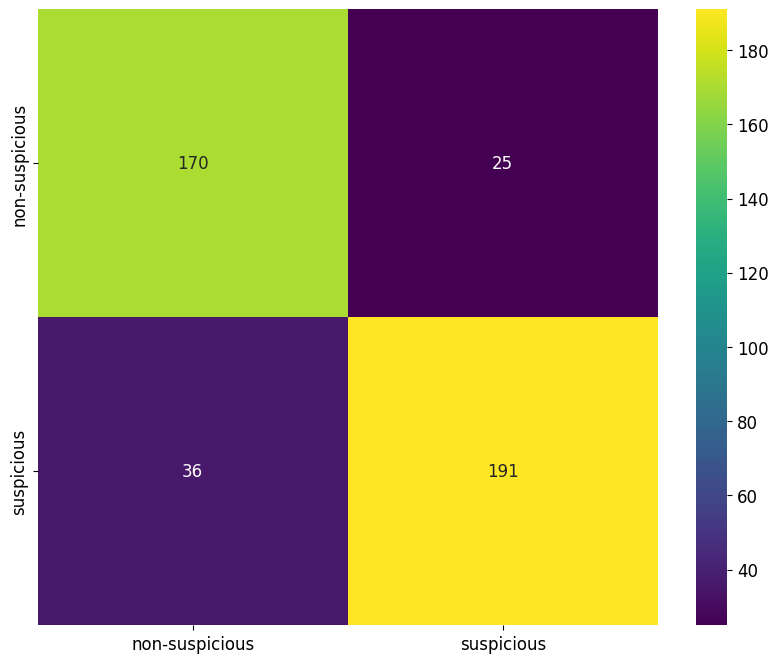

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_pred,y_test),annot=True,fmt='.3g',xticklabels=classes,yticklabels=classes,cmap='viridis')
plt.show()

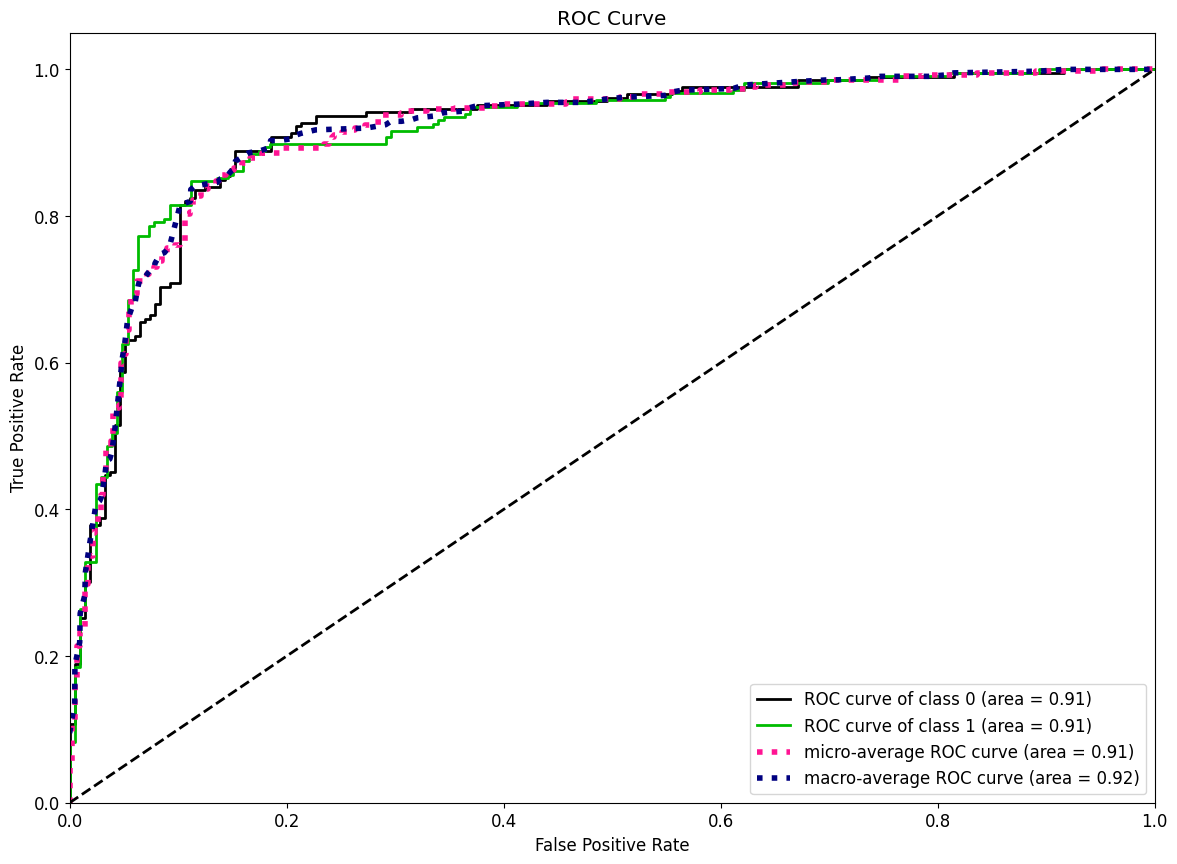

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt

# y_test = # ground truth labels
# y_pred = # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_test, y_preds, figsize=(14,10), 
                            #  curves=('micro'),
                             title='ROC Curve')
plt.show()

In [ ]:

from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred)

0.8547509888529305